In [ ]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import statsmodels.api as sm

plt.style.use('seaborn-v0_8')

## Основные функции

In [ ]:
def process_log(file, temperature):
    '''
    Обрабатывает данные из log файлов
    
    Args:
        file (str): название файла
        temperature (float): значение температуры для рассчета теплоёмкости
        
    '''
    

    df = pd.read_csv(file, sep='\t')

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].plot(df['Step'], df['Energy'])
    axs[1].plot(df['Step'], df['MagMom'])
    axs[0].set_title('Energy')
    axs[1].set_title('Magnetization')
    axs[0].set_xlabel('Step')
    axs[1].set_xlabel('Step')

    energy = df['Energy'][100:]
    print(f'Mean energy: {energy.mean():.3f}', f'Std energy: {energy.std():.3f}', sep='\n')
    print(f'Mean magnetization: {df["MagMom"].mean():.3f}', f'Std magnetization: {df["MagMom"].std():.3f}', sep='\n')

    capacity = energy.std() ** 2 / temperature ** 2
    print(f'Specific heat capacity: {capacity:.5f}')

In [ ]:

def ising(temperature, grid_size, ncycles, dump_rate, print_output=True, process_data=True):
    
    """Запускает процесс расчёта модели изинга
    
    Args:
        temperature (float)
        grid_size (int)
        dump_rate (int): частота записи файлов
        print_output (bool): флаг для печати свойств системы (энергии, магнитного момента) с частотой dump_rate
        process_data (bool): флаг для вывода энергии и магнитного момента системы от времени в течение всей симуляции
    
    """
    
    
    def MKstep(E, M):
    
        x = np.random.randint(0, grid_size)
        y = np.random.randint(0, grid_size)
    
        curr_spin = grid[x, y]
        
        top = grid[x, (y - 1) % grid_size]
        left = grid[(x - 1) % grid_size, y]
        bottom = grid[x, (y + 1) % grid_size]
        right = grid[(x + 1) % grid_size, y]
        delta_E = 2 * curr_spin * (top + left + bottom + right)    
        
        xi = np.random.random()
    
        if (xi < np.exp(- delta_E / temperature)):
            
            grid[x, y] *= -1
            return E + delta_E, M + 2 * grid[x, y] / grid_size ** 2
        
        return E, M
    
    def save_xyz(file, grid, step):
        N = grid_size ** 2
        file.write(f"{N}\n")
        file.write(f"Step: {step}\n")
        for x in range(grid_size):
            for y in range(grid_size):
                spin = grid[x, y]
                file.write(f"Fe {x} {y} {spin}\n")
        
    
    # grid = np.random.randint(0, 2, (grid_size, grid_size)) * 2 - 1
    grid = np.ones((grid_size, grid_size))
    
    E = 0
    M = 0
    for x in range(grid_size):
        for y in range(grid_size):
            curr_spin = grid[x, y]
            
            top = grid[x, (y - 1) % grid_size]
            left = grid[(x - 1) % grid_size, y]
            bottom = grid[x, (y + 1) % grid_size]
            right = grid[(x + 1) % grid_size, y]
            
            
            E_i = - 0.5 * curr_spin * (top + left + bottom + right)
            M += curr_spin
            E += E_i
    
    M /= grid_size ** 2
    # return E, M

    output_file = f'./dumps_{grid_size}/ising_{temperature}.xyz'
    log_file = f'./logs_{grid_size}/ising_{temperature}.log'
    with open(output_file, 'w') as file:
        with open(log_file, 'w') as log:
            log.write('Step\tEnergy\tMagMom\n')
            if print_output: print('Step', 'Energy', 'MagMom', sep='\t')
            for i in range(ncycles+1):
                E, M = MKstep(E, M)
                if i % dump_rate == 0: 
                    save_xyz(file, grid, i)
                    
                    if print_output: print(i, f'{E / grid_size ** 2:4.5f}', f'{M:.5f}', sep='\t')
                    log.write(f'{i}\t{E / grid_size ** 2:4.5f}\t{M:1.5f}\n')
                
    if process_data:process_log(log_file, temperature)


## Сетка 20x20

Mean energy: -1.997
Std energy: 0.008
Mean magnetization: 0.999
Std magnetization: 0.002
Specific heat capacity: 0.00004


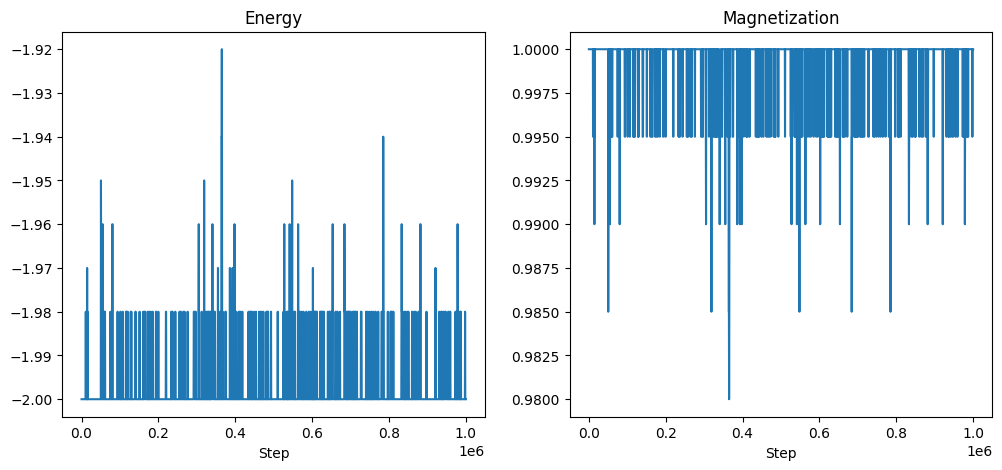

In [197]:
ising(temperature=1, grid_size=20, ncycles=1000000, dump_rate=500, print_output=False, process_data=True)

In [ ]:



from concurrent.futures import ThreadPoolExecutor

temperatures = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.3, 2.35, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6]
grid_size = 20
ncycles = 1000000
dump_rate = 500

def run_ising(temp):
    ising(temperature=temp, grid_size=grid_size, ncycles=ncycles, dump_rate=dump_rate, print_output=False, process_data=False)

with ThreadPoolExecutor() as executor:
    executor.map(run_ising, temperatures)        
    

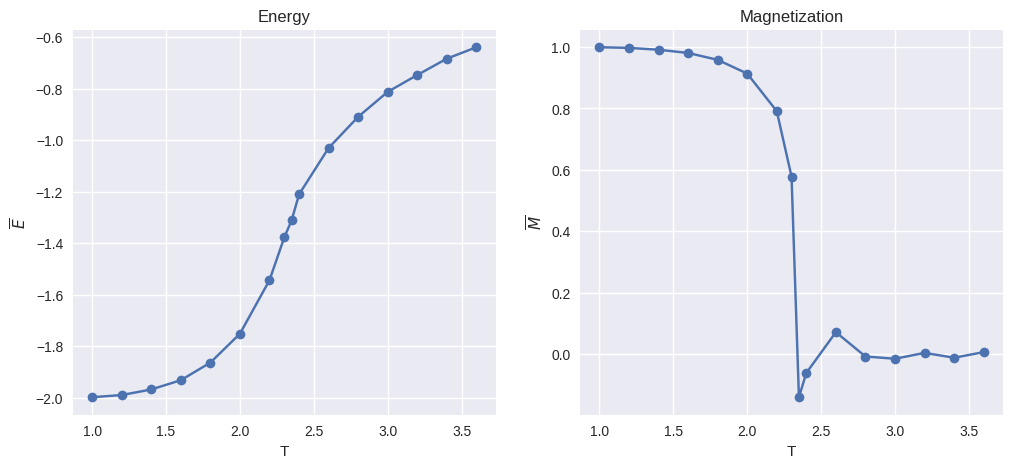

In [43]:
logs = sorted(os.listdir('./logs_20'), key=lambda x: float(x.split('_')[1].split('.log')[0]))
T = [float(log.split('_')[1].replace('.log', '')) for log in logs]
E = []
E_vars = []
M = []

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for file in logs:
    df = pd.read_csv('./logs_20/' + file, sep='\t')
    energy = df['Energy'][100:]
    E.append(energy.mean())
    E_vars.append(energy.var())
    M.append(df['MagMom'][100:].mean())

axs[0].plot(T, E, marker='o')
axs[0].set_xlabel('T')
axs[0].set_ylabel('$\overline{E}$')
axs[0].set_title('Energy')
axs[1].plot(T, M, marker='o')
axs[1].set_xlabel('T')
axs[1].set_ylabel('$\overline{M}$')
axs[1].set_title('Magnetization');


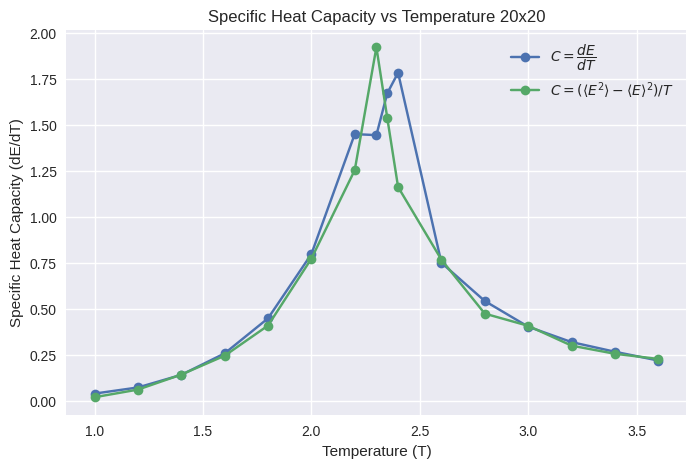

In [45]:
dE_dT = np.gradient(E, T)

plt.figure(figsize=(8, 5))
plt.plot(T, dE_dT, marker='o', label='$C = \dfrac{dE}{dT}$')
plt.xlabel('Temperature (T)')
plt.ylabel('Specific Heat Capacity (dE/dT)')
plt.title('Specific Heat Capacity vs Temperature 20x20')
# plt.grid(True)


heat_capacity = np.array(E_vars) / np.array(T) ** 2

plt.plot(T, heat_capacity * 400, marker='o', label=r'$C= (\langle E^2\rangle - \langle E \rangle ^ 2) / T$')

plt.legend()
plt.show()

## Сетка 100x100

Mean energy: -1.547
Std energy: 0.024
Mean magnetization: 0.795
Std magnetization: 0.025
Specific heat capacity: 0.00012
CPU times: user 1min 4s, sys: 315 ms, total: 1min 4s
Wall time: 1min 4s


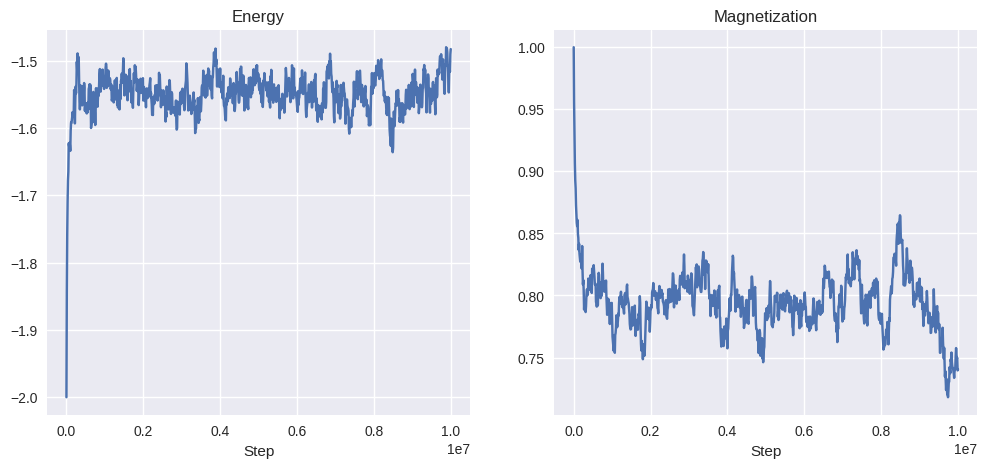

In [94]:
%%time
ising(temperature=2.2, grid_size=100, ncycles=10000000, dump_rate=10000, print_output=False, process_data=True)

In [91]:
from concurrent.futures import ThreadPoolExecutor

temperatures = [1.6, 1.8]
grid_size = 100
ncycles = 10000000
dump_rate = 10000

def run_ising(temp):
    ising(temperature=temp, grid_size=grid_size, ncycles=ncycles, dump_rate=dump_rate, print_output=False, process_data=False)

with ThreadPoolExecutor() as executor:
    executor.map(run_ising, temperatures)

354.1083829023152
313.63476209529927
975.9755736031747
475.4699739210209
110.51613534007123
717.7023829903881
48.83895367352618
9.232277073828637
9.999497133945235
9.592036868674093
46.12384719992162
32.038600895027315
45.81708434008213
134.77178275723762
110.12608052375485
479.6702451204597


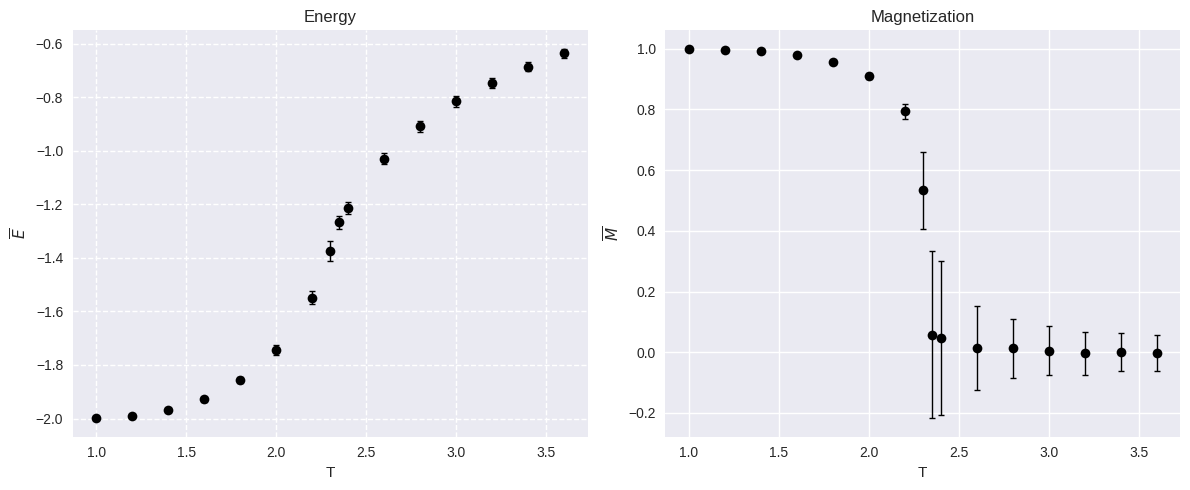

In [157]:
logs = sorted(os.listdir('./logs_100'), key=lambda x: float(x.split('_')[1].split('.log')[0]))
T = np.array([float(log.split('_')[1].split('.log')[0]) for log in logs])
E = []
E_vars = []
M = []
M_vars = []
M_errs = []
sigma_cv_T2 = []
sigma_chi_T = []

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for file in logs:
    df = pd.read_csv('./logs_100/' + file, sep='\t')
    energy = df['Energy'][200:]
    E.append(energy.mean())
    E_vars.append(energy.var())
    M.append(df['MagMom'][200:].mean())
    M_vars.append(df['MagMom'].var())

    E_mean = np.mean(energy)
    E2_mean = np.mean(energy**2)

    sigma_E = np.std(energy, ddof=1)
    sigma_E2 = np.std(energy**2, ddof=1)

    sigma_E_mean = sigma_E / np.sqrt(len(energy))
    sigma_E2_mean = sigma_E2 / np.sqrt(len(energy))
    
    sigma_cv_T2.append(np.sqrt(sigma_E2_mean**2 + 4 * E_mean**2 * sigma_E_mean**2))

    
    data = df['MagMom'][300:]
    M_mean = np.mean(data)
    M2_mean = np.mean(data**2)

    # Оценки стандартных отклонений
    sigma_M = np.std(data, ddof=1)
    sigma_M2 = np.std(data**2, ddof=1)

    # Ошибки средних
    sigma_M_mean = sigma_M / np.sqrt(len(data))
    sigma_M2_mean = sigma_M2 / np.sqrt(len(data))

    sigma_chi_T.append(np.sqrt(sigma_M2_mean**2 + 4 * M_mean**2 * sigma_M_mean**2))
    
    
    
    # Поскольку в какой-то момент становиться сложным считать погрешность выборочной дисперсией,
    # (чем ближе к точке Кюри, тем дольше ждать выхода на равновесия и тем самым всё равно придется получать точки не по совсем
    # н.о.р.с.в, поэтому делаем вот такой трюк, который считает дисперсию для (вообще говоря всё ещё одинаково распределенных) зависимых)
    # но вобщем вообще эти точки лучше не считать, конечно
    corr = sm.tsa.acf(data, nlags=100, fft=True)  # автокорреляционная функция
    tau = np.sum(corr)  # интегральное время корреляции
    N_eff = len(data) / tau  # эффективное число независимых выборок
    print(N_eff)
    std_error = np.std(data, ddof=1) / np.sqrt(N_eff)  # скорректированная ошибка среднего
    N_eff, std_error
    
    M_errs.append(std_error)

    
axs[0].errorbar(T, E, fmt='ok', yerr=np.array(E_vars) ** 0.5, elinewidth=1, capsize=2, capthick=1)
axs[0].set_xlabel('T')
axs[0].set_ylabel('$\overline{E}$')
axs[0].set_title('Energy')
axs[0].grid(True, linestyle='--')
axs[1].errorbar(T, M, yerr=np.array(M_vars) ** 0.5, fmt='ok', elinewidth=1, capthick=1, capsize=2)
axs[1].set_xlabel('T')
axs[1].set_ylabel('$\overline{M}$')
axs[1].set_title('Magnetization');

plt.tight_layout()
plt.savefig('./img/en_mag100.png')


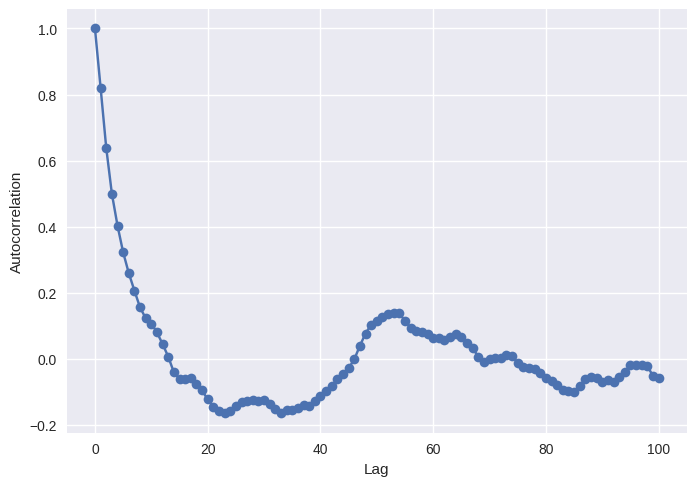

In [102]:

plt.plot(corr, marker='o')
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()


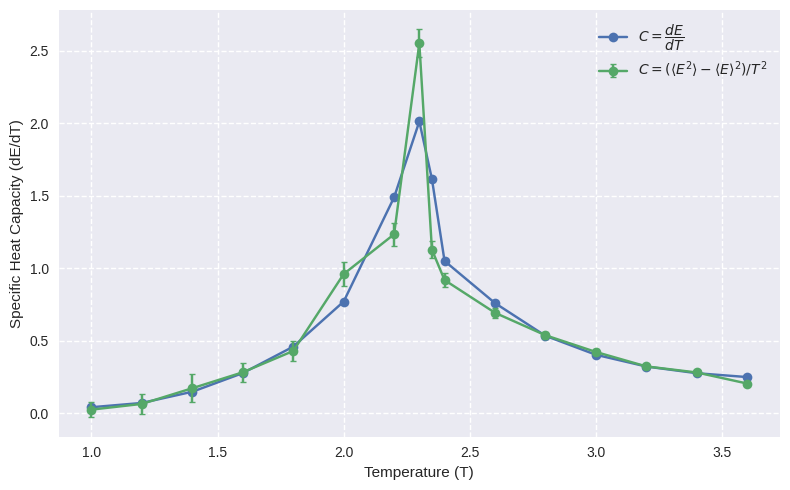

In [150]:
dE_dT = np.gradient(E, T)

plt.figure(figsize=(8, 5))
plt.plot(T, dE_dT, marker='o', label='$C = \dfrac{dE}{dT}$')
plt.xlabel('Temperature (T)')
plt.ylabel('Specific Heat Capacity (dE/dT)')
plt.grid(True, linestyle='--')



E = np.array(E)
T = np.array(T)


heat_capacity = np.array(E_vars) / np.array(T) ** 2
sigma_cv = sigma_cv_T2 / T ** 2 * 1e2 # Потому что корень из N один лишний учтен из-за удельной энергии в промежуточных расчётах

# Поскольку я считываю удельную энергию, то E^2 дает удельную теплоемкость 
# в N раз меньше, поэтому необходимо внести домножение на число частиц
plt.errorbar(T, heat_capacity * 1e4, marker='o', yerr=sigma_cv, capsize=2, capthick=1,
             label=r'$C = (\langle E^2\rangle - \langle E \rangle ^ 2) / T ^ 2$')

plt.legend()
plt.tight_layout()
plt.savefig('./img/capacity.png')
plt.show()

In [158]:
sigma_chi_T

[8.693683041112013e-05,
 0.00015126821988790866,
 0.0003286371810334285,
 0.0002710814550952362,
 0.0004647440447375557,
 0.0009828061514190847,
 0.001985382565049731,
 0.0058564988143316645,
 0.0012160974321251052,
 0.000815602616585992,
 0.00018189878099474435,
 0.00010966344929768978,
 5.6518768478023976e-05,
 5.651711085444766e-05,
 3.113873746098426e-05,
 3.149238220577221e-05]

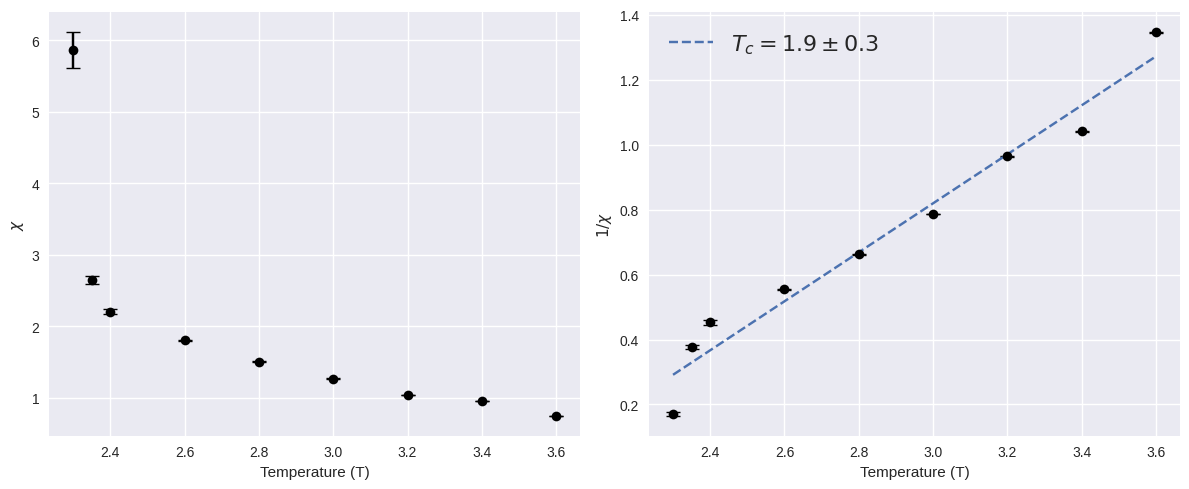

In [191]:
from scipy.stats import linregress
from uncertainties import ufloat
st = 7

chi = (np.array(E_vars) / np.array(T))[st:] * 1e4
T_positive = np.array(T[st:])


sigma_chi = (sigma_chi_T / T) [st:] * 1e2


fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

axs[0].errorbar(T_positive, chi, yerr=sigma_chi, capsize=5, capthick=1, fmt='ok')
axs[0].set_xlabel('Temperature (T)')
axs[0].set_ylabel('$\chi$')

chi_inv_errs = [(1 / ufloat(x, y)).std_dev for x, y in zip(chi, sigma_chi)]
axs[1].errorbar(T_positive, 1 / chi, yerr=chi_inv_errs, capsize=5, capthick=1, fmt='ok')
axs[1].set_xlabel('Temperature (T)')
axs[1].set_ylabel('$1 / \chi$')

res = linregress(T_positive, 1 / chi)
Tc_estimate = - ufloat(res.intercept, res.intercept_stderr) / ufloat(res.slope, res.stderr)
axs[1].plot(T_positive, T_positive * res.slope + res.intercept, linestyle='--', label=f'$T_c = {Tc_estimate.nominal_value:.1f} \pm {Tc_estimate.std_dev:.1f}$')
axs[1].legend(fontsize=16);

plt.tight_layout()
plt.savefig('./img/chi.png')
# plt.plot(T_positive, 1 / (T_positive - 2.2) / 1e4);